## Test weighted training

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ["TOKENIZERS_PARALLELISM"]="false"
os.environ["AWS_REGION_NAME"] = 'us-east-1'

In [5]:
import torch
torch.multiprocessing.set_start_method('spawn')

In [6]:
## setup a test population
from src.utils.script_utils import get_datasets
from src.utils.data_utils import perform_query_integration

In [7]:
import pandas as pd

In [8]:
org_data_train, org_data_test, org_data_val = get_datasets("ragtruth", group="QA")
querymode = "queryonly"
org_data_train.df = perform_query_integration(org_data_train.df, mode=querymode)
org_data_test.df = perform_query_integration(org_data_test.df, mode=querymode)

891
882
882


In [7]:
from torch.utils.data import DataLoader

In [22]:
run = "rmiss_eval3_v2_ensemble-mean_ragtruth_QA"
useiter = 0

In [21]:
mydf = pd.read_csv(f"runs/{run}/data_iteration_{useiter}.csv")

In [23]:
len(mydf)

5024

In [24]:
from src.utils.script_utils import init_population_from_dump
from src.sync_data.evaluators import dataset_from_population

In [25]:
dataset = dataset_from_population(init_population_from_dump(mydf))

In [26]:
dataset

In [27]:
from src.sync_data.evaluators import NLIFinetuningEvaluation 

In [28]:
myeval = NLIFinetuningEvaluation(org_data_test, "tasksource", weighted=True, num_epochs=1, batch_size=2)

In [29]:
myeval(init_population_from_dump(mydf), None)

init trainer.


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Step,Training Loss


KeyboardInterrupt: 

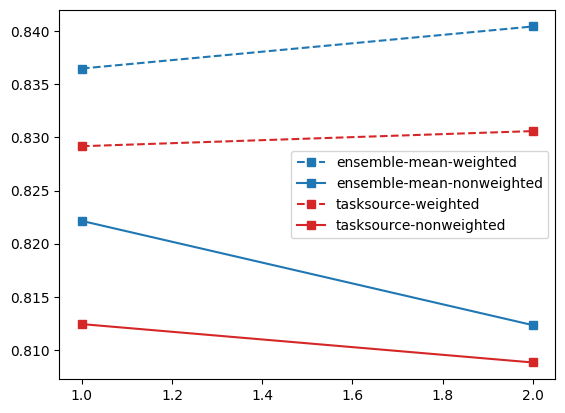

In [19]:
## Val performance weighted vs unweighed.
import json
import matplotlib.pyplot as plt
import numpy as np
for model, clr in zip(["ensemble-mean", "tasksource"], ["tab:blue", "tab:red", "tab:green"]):
    unweighted1 = json.load(open(f"runs/rmiss_eval3_v2_{model}_ragtruth_QA/eval_out_list.json"))
    weighted1 = json.load(open(f"runs/rmiss_eval3_v2_{model}_ragtruth_QA/eval_out_weighted_list.json"))
    iters = np.array([1, 2])
    
    unweighted2 = json.load(open(f"runs/rmiss_eval3_v3_{model}_ragtruth_QA/eval_out_list.json"))
    weighted2 = json.load(open(f"runs/rmiss_eval3_v3_{model}_ragtruth_QA/eval_out_weighted_list.json"))
    iters = np.array([1, 2])
    plt.plot(iters, [0.5*(weighted1[str(idx)]["roc"]+weighted2[str(idx)]["roc"]) for idx in iters], "--s", c=clr, label=f"{model}-weighted")
    plt.plot(iters, [0.5*(unweighted1[str(idx)]["tasksource"]["roc"]+unweighted2[str(idx)]["tasksource"]["roc"]) for idx in iters], "-s", c=clr, label=f"{model}-nonweighted")
plt.xlabel(")
plt.legend()

In [1]:
from src.sync_data.initial_generators import FromFile

src.cross_encoder_model.my_evaluator


In [14]:
mygen = FromFile(select_max_cert=False)

In [15]:
res = mygen.generate_samples(org_data_train, 4)

629


In [16]:
len(res)

5032

In [17]:
tag_list = list(res.tags)

In [18]:
res.get_initial_prob(tag_list[1])

array([0.93665904, 0.6143679 , 0.9550464 , 0.92129517])

In [13]:
res.get_initial_prob(tag_list[1])

array([0.9883592 , 0.98628414, 0.98364073, 0.9829852 ])

In [28]:
from sentence_transformers import CrossEncoder
from src.cross_encoder_model.model_wrappers import OneWayCrossEncoder

In [29]:
model = OneWayCrossEncoder(
    'cross-encoder/nli-deberta-v3-base',
    num_labels=3,
    device="cuda",
    automodel_args={"ignore_mismatched_sizes": True},
)